In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# constants which are same from training
IMG_SIZE = 224
NUM_ACTIONS = 9
HISTORY_SIZE = 0
MAX_STEPS = 30

# building VGG16 feature extractor
def build_feature_extractor():
    vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
    feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=vgg16.layers[20].output)
    feature_extractor.trainable = False
    return feature_extractor

# same state extractor as in RL_epsilon1.py
def extract_state(image, history, feature_extractor):
    image_resized = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image_resized = tf.expand_dims(image_resized, axis=0)  # (1, IMG_SIZE, IMG_SIZE, 3)
    features = feature_extractor(image_resized)
    features_flat = tf.reshape(features, [-1])

    history_onehot = tf.one_hot(history, depth=NUM_ACTIONS, dtype=tf.float32)
    history_flat = tf.reshape(history_onehot, [-1])

    return tf.concat([features_flat, history_flat], axis=0)

# helper function to just process image
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
    return img_rgb

# helper function to just process the mask
def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.uint8)
    return mask

# same compute_mask as in training .py file
def compute_mask(action, box):
    alpha = 0.2
    delta_w = alpha * (box[2] - box[0])
    delta_h = alpha * (box[3] - box[1])
    x1, y1, x2, y2 = box

    if action == 0:  # move right
        x1 += delta_w
        x2 += delta_w
    elif action == 1:  # move left
        x1 -= delta_w
        x2 -= delta_w
    elif action == 2:  # move up
        y1 -= delta_h
        y2 -= delta_h
    elif action == 3:  # move down
        y1 += delta_h
        y2 += delta_h
    elif action == 4:  # zoom in (keeping proportions the same)
        x1 += delta_w
        x2 -= delta_w
        y1 += delta_h
        y2 -= delta_h
    elif action == 5:  # zoom out (keeping proportions the same)
        x1 -= delta_w
        x2 += delta_w
        y1 -= delta_h
        y2 += delta_h
    elif action == 6:  # vertical zoom (squish height)
        y1 += delta_h
        y2 -= delta_h
    elif action == 7:  # horizontal zoom (squish width)
        x1 += delta_w
        x2 -= delta_w

    x1, x2 = np.clip([x1, x2], 0, IMG_SIZE)
    y1, y2 = np.clip([y1, y2], 0, IMG_SIZE)
    x1, x2 = sorted([x1, x2])
    y1, y2 = sorted([y1, y2])
    return [x1, y1, x2, y2]

# same function as in training .py file
def crop_image(img, box):
    x1, y1, x2, y2 = map(int, box)
    cropped = img[y1:y2+1, x1:x2+1]
    return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE)) if cropped.size else np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

In [ ]:
# new visualization function for a specific image

def visualize_agent_on_image(model_path, patient_ct):
    # load models
    model = tf.keras.models.load_model(model_path)
    feature_extractor = build_feature_extractor()

    # load image and mask
    image_path = 'hemorrhage_CT/images/' + patient_ct + '.jpg'
    mask_path = 'hemorrhage_CT/masks/' + patient_ct + '_HGE_Seg.jpg'
    img = preprocess_image(image_path)
    mask = preprocess_mask(mask_path)
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # get ground truth box
    ys, xs = np.where(mask > 0)
    gt_box = [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]

    # initialize agent
    history = [-1] * HISTORY_SIZE
    box = [0, 0, IMG_SIZE, IMG_SIZE]
    trajectory = [box.copy()]
    actions = []
    done = False
    step = 0

    current_image_tensor = img_tensor
    # running agent
    while not done:
        current_image_tensor = crop_image(img, box)
        state = extract_state(current_image_tensor, history, feature_extractor)
        state = tf.expand_dims(state, axis=0)

        q_values = model.predict(state, verbose=0)[0]

        # just for debugging
        print(q_values)
        action = np.argmax(q_values) # print best action

        # terminate agent if it quits
        if action == 8:
            done = True
            break

        box = compute_mask(action, box)
        trajectory.append(box.copy())
        actions.append(action)
        # update history if it exists
        if HISTORY_SIZE > 0:
            history = history[1:] + [action]
        step += 1

        # break if we hit MAX_STEPS
        if step == MAX_STEPS:
            break

    # plot results
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # plot first image of hemorrhage in red along with gt box
    axes[0].imshow(img)
    axes[0].imshow(mask, alpha=0.3, cmap='Reds')
    rect = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2] - gt_box[0], gt_box[3] - gt_box[1],
                              linewidth=2, edgecolor='green', facecolor='none')
    axes[0].add_patch(rect)
    axes[0].set_title("Ground Truth Tumor and Box")
    axes[0].axis('off')

    # plot second image of our trajectory overlaid on the hemorrhage itself
    axes[1].imshow(img)
    axes[1].imshow(mask, alpha=0.3, cmap='Reds')
    num_steps = len(trajectory)
    for idx, b in enumerate(trajectory[:-1]):
        # shift color as you go to see how agent is moving over time
        color = (0, 0.5 + 0.5 * idx / num_steps, 1.0)
        rect = patches.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1],
                                 linewidth=1.5, edgecolor=color, facecolor='none', linestyle='--')
        axes[1].add_patch(rect)

    # plot with final box in green
    final_box = trajectory[-1]
    final_rect = patches.Rectangle((final_box[0], final_box[1]), final_box[2] - final_box[0], final_box[3] - final_box[1],
                                   linewidth=2.5, edgecolor='lime', facecolor='none')
    axes[1].add_patch(final_rect)
    axes[1].set_title("Agent Trajectory and Final Box")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
    
    print(actions)

[-20.301535 -17.904331 -15.857794 -19.695152 -16.054817 -19.678303
 -15.847254 -20.303837 -34.759525]
[-19.833513 -17.727285 -15.69388  -19.387245 -16.03388  -19.007742
 -15.829864 -19.775345 -33.539185]
[-18.76865  -16.825157 -15.329805 -18.166225 -15.027884 -18.273151
 -14.787635 -19.065327 -32.391964]
[-18.790354  -16.985064  -15.82109   -18.352255  -15.0897255 -18.058935
 -15.181341  -18.967424  -32.474163 ]
[-21.704828 -17.175879 -17.889929 -20.756767 -18.929947 -18.621004
 -17.541082 -21.977995 -33.51741 ]
[-19.812325 -17.838318 -17.509281 -19.518694 -16.78809  -18.378216
 -16.659935 -20.346294 -33.0779  ]
[-20.210016 -18.767363 -17.35968  -20.396044 -17.003473 -18.697718
 -17.556505 -20.293154 -33.325462]
[-23.722858 -18.804497 -19.166878 -23.195517 -20.991617 -19.73026
 -20.025948 -23.618057 -34.953896]
[-22.012707 -19.800152 -18.663893 -22.301535 -18.653872 -19.989052
 -19.140839 -22.072384 -35.540543]
[-24.229294 -21.118637 -19.972832 -24.269361 -21.283575 -21.071775
 -21.176

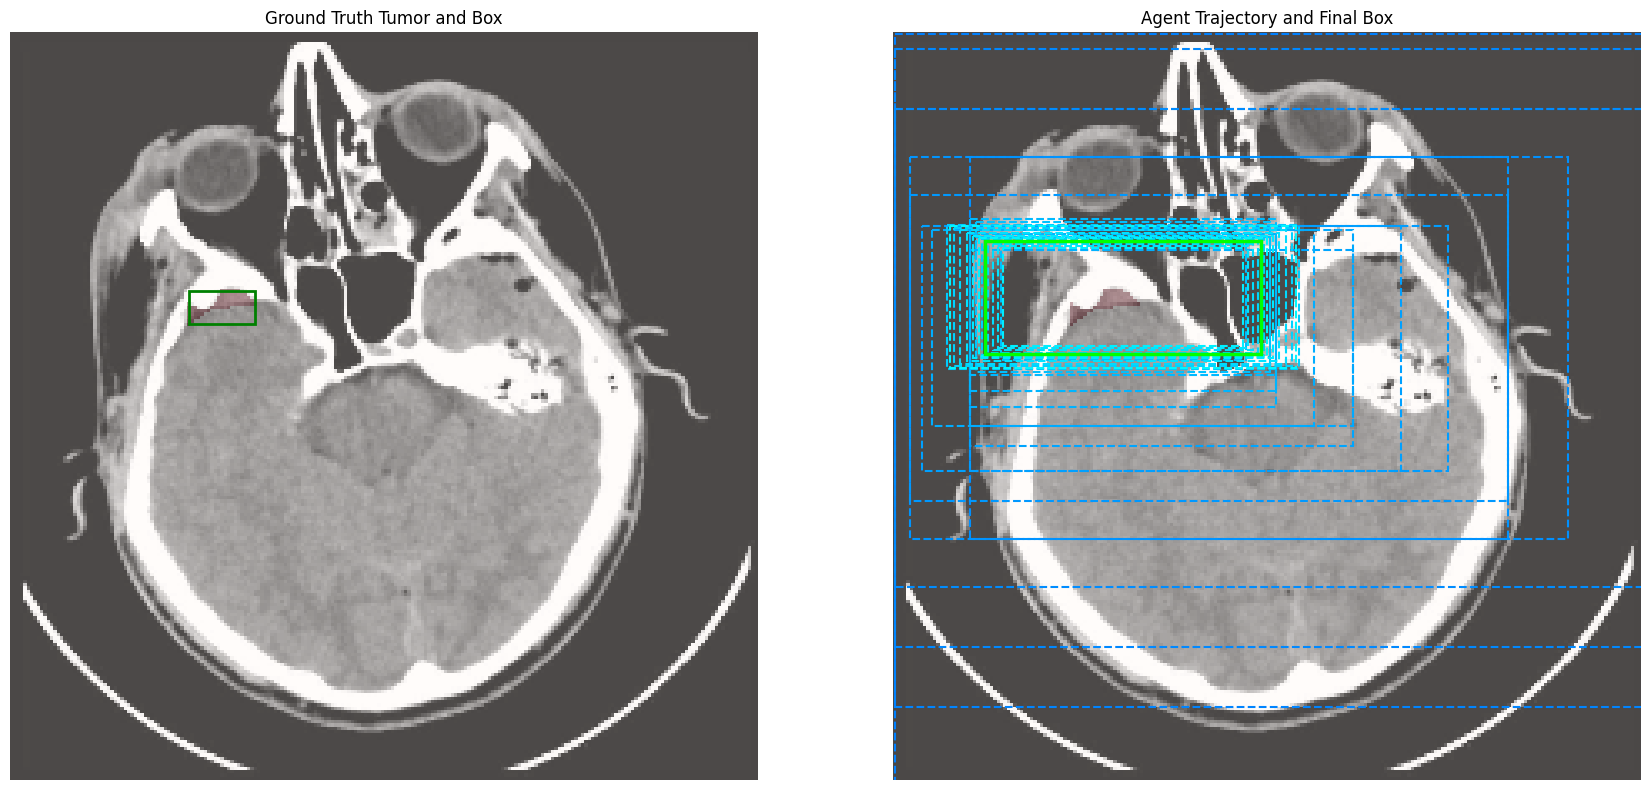

[6, 2, 6, 4, 1, 6, 4, 1, 4, 2, 1, 4, 2, 2, 4, 5, 6, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 5, 4]


In [ ]:
model_path = 'dqn_1_model_coord_ee.keras'  # model file
patient_ct = '049_14'

visualize_agent_on_image(model_path, patient_ct)

In [3]:
model = tf.keras.models.load_model("dqn_model_manhattana.keras")
print(model.input_shape)

(None, 4132)
